# Model Development
------------
In this notebook I will train and test a classifier on text data and candidate features.

I will start with a simple classifier such as `random forest`.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, plot_confusion_matrix
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
import joblib
import umap
from scipy.sparse import vstack, hstack

from pathlib import Path
import sys
sys.path.append("..")

from rustoked.data_processing import(
    clean_raw_dataframe,
    get_labels,
    get_normalized_series,
    get_features
)

from bokeh.plotting import figure, output_notebook, show
from bokeh.models import HoverTool,ColumnDataSource, CategoricalColorMapper

import warnings
warnings.filterwarnings('ignore')
%reload_ext autoreload
%autoreload 2

Load data as a dataframe, clean it, and add features to it

In [2]:
data_source = Path("../data/raw_data.csv")
df = pd.read_csv(data_source)
df = clean_raw_dataframe(df.copy())
df = get_features(df.copy())

I have been using following function throughout this notebook:

In [3]:
def get_vectorizer(df):
    """
    Create a vectorizer and train it for further use.
    It should be fitted with training set preventing data leakage
    :param df: training data set
    :return : a fitted tfidf vectorizer instance
    """
    vectorizer = TfidfVectorizer(
        strip_accents='ascii', max_df=0.5, min_df=5, max_features=5000
    )
    
    vectorizer.fit(df['reviews'].copy())
    return vectorizer

def get_vectors_list(text_series, vectorizer):
    """
    Vectorise a series of texts and map it to a list
    :param text_series: a pandas series of texts
    :param vectorizer: a fitted instance of sklearn tfidf vectorizer
    :return: a list of vectors
    """
    vectors = vectorizer.transform(text_series)
    vectors_list = [vectors[i] for i in range(vectors.shape[0])]
    return vectors_list

def get_feature_and_label(df, feature_cols=None):
    """
    generate and return both sets of features and labels
    required for classifier model training and predictions
    :param df: a dataframe instance of training or testing set
    :param feature_cols: a list of columns name required to be included
                         and plugged into vectors of text features
    :return: features in form of sparse matrix and labels series
    """
    if not feature_cols:
        features = vstack(df['vectors'])
    else:
        text_features = vstack(df['vectors'])
        helping_features = df[feature_cols].astype(float)
        features = hstack([text_features, helping_features])
    labels = df['labels']
    return features, labels
    
    
def get_metrics(true_labels, predicted_labels):
    """
    print out evaluation metrics for the model
    :param true_labels: a series of true labels
    :param predicted labels: a series of predicted labels
    :return: print performance metrics including:
             precision, recall, f1-score, accuracy, macro & weighted averages
             
    Just as a reminder:
        precision = tp / (tp + fp)
        recall = tp / (tp + fn)
        f1 = 2*(precision * recall) / (precision + recall)
    """
    print(classification_report(true_labels, predicted_labels))
    

def get_cm_plot(classifier, features, labels):
    """
    plot the confusion matrix for classifier
    :param classifier: the classifier model instance
    :param features: sparse matrix of features feeding the model
    :param labels: a series of true labels
    :return: plot the confusion matrix
    """
    classes = ['Dissatisfied', "Disengaged", 'Stoked']
    plot_confusion_matrix(classifier, features, labels,
                          cmap=plt.cm.Greys,
                          display_labels=classes)
    plt.title("Confusion Matrrix")
    
    
def get_feature_importance(vectorizer, classifier, feature_cols=None, num=20):
    """
    print out a certain number of Top & Bottom important features
    :param vectorizer: the fitted instance of tfidf vectorizer
    :param classifier: the classifier model
    :param feature_cols: a list of columns name required to be included
                         and plugged into vectors of text features
    :param num: The number of Top or Bottom important features to be printed
    :return: print a certain number of Top & Bottom important features
    """
    feature_names = vectorizer.get_feature_names()
    if not feature_cols:
        feature_names = np.array(feature_names)
    else:
        feature_names.extend(feature_cols)
        feature_names = np.array(feature_names)
    feature_importances = clf.feature_importances_
    indices = np.argsort(feature_importances)[::-1]
    all_features = list(zip(feature_names[indices], feature_importances[indices]))
        
    print("{} most important features :\n".format(num))
    for feature in all_features[:num]:
        print("{}  :  {}".format(feature[0], feature[1]))
        
    print("\n{} less important features :\n".format(num))
    for feature in all_features[-num:]:
        print("{}  :  {}".format(feature[0], feature[1]))

Split the data set into training and testing sets, then getting the `tfidf vectorizer` and `random forest` classifier ready.

In [4]:
train_df, test_df = train_test_split(df, test_size=0.2, random_state=69)
vectorizer = get_vectorizer(train_df)

train_df['vectors'] = get_vectors_list(train_df['reviews'], vectorizer)
test_df['vectors'] = get_vectors_list(test_df['reviews'], vectorizer)

clf = RandomForestClassifier(n_estimators=100, class_weight='balanced', oob_score=True, n_jobs=2)

### model_v1

I will train and evaluate the first model on text data itself with none of engineered candidate features.

In [5]:
X_train, y_train = get_feature_and_label(train_df)
X_test, y_test = get_feature_and_label(test_df)

clf.fit(X_train, y_train)

y_predicted = clf.predict(X_test)

In [6]:
# Performance metrics for training set
""" see: https://scikit-learn.org/stable/auto_examples/ensemble/
    plot_ensemble_oob.html#sphx-glr-auto-examples-ensemble-plot-ensemble-oob-py """

oob_train = np.argmax(clf.oob_decision_function_, axis=1)
get_metrics(y_train, oob_train)

              precision    recall  f1-score   support

           0       0.67      0.71      0.69      2930
           1       0.44      0.05      0.09      1870
           2       0.70      0.92      0.80      4880

    accuracy                           0.69      9680
   macro avg       0.61      0.56      0.53      9680
weighted avg       0.64      0.69      0.63      9680



In [7]:
# Performance metrics for testing set
get_metrics(y_test, y_predicted)

              precision    recall  f1-score   support

           0       0.69      0.71      0.70       736
           1       0.54      0.03      0.06       489
           2       0.69      0.94      0.79      1196

    accuracy                           0.69      2421
   macro avg       0.64      0.56      0.52      2421
weighted avg       0.66      0.69      0.62      2421



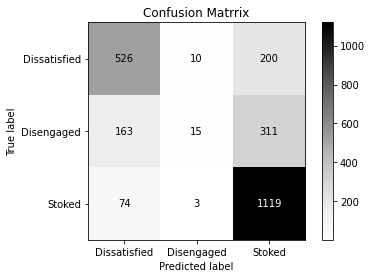

In [8]:
get_cm_plot(clf, X_test, y_test)

well it seems that the model is performing pretty well on predicting label `class-2`. The performance on label `class-0` is also acceptable by predicting the majority of labels correctly. But it is hugely struggling with label `class-1`, as expected though.

### model_v2

I will plug in features generated in other [notebook](https://github.com/mohsen-saki/RUStoked/blob/master/notebooks/feature_engineering.ipynb) to see if they can improve the model performance specially for label `class-1`. First, I will go with features named as `Approach#1`.

In [9]:
features = [
    "has_positive",
    "has_but",
    "has_negative",
    "review_len"
]

X_train, y_train = get_feature_and_label(train_df, features)
X_test, y_test = get_feature_and_label(test_df, features)

clf.fit(X_train, y_train)

y_predicted = clf.predict(X_test)

In [10]:
# Performance metrics for training set
oob_train = np.argmax(clf.oob_decision_function_, axis=1)
get_metrics(y_train, oob_train)

              precision    recall  f1-score   support

           0       0.66      0.71      0.69      2930
           1       0.46      0.06      0.10      1870
           2       0.70      0.91      0.79      4880

    accuracy                           0.68      9680
   macro avg       0.61      0.56      0.53      9680
weighted avg       0.64      0.68      0.63      9680



In [11]:
# Performance metrics for testing set
get_metrics(y_test, y_predicted)

              precision    recall  f1-score   support

           0       0.69      0.74      0.71       736
           1       0.49      0.04      0.07       489
           2       0.69      0.93      0.79      1196

    accuracy                           0.69      2421
   macro avg       0.62      0.57      0.53      2421
weighted avg       0.65      0.69      0.62      2421



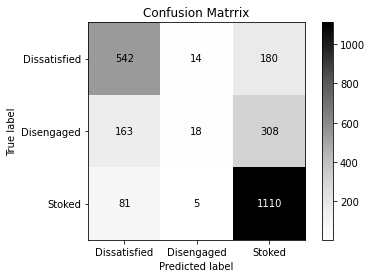

In [12]:
get_cm_plot(clf, X_test, y_test)

### model_v3
Training a model with other candidate features named as `Approach#2`.

In [13]:
features = [
    "review_len",
    "pos_neg_factor"
]

X_train, y_train = get_feature_and_label(train_df, features)
X_test, y_test = get_feature_and_label(test_df, features)

clf.fit(X_train, y_train)

y_predicted = clf.predict(X_test)

In [14]:
# train set metrics
oob_train = np.argmax(clf.oob_decision_function_, axis=1)
get_metrics(y_train, oob_train)

              precision    recall  f1-score   support

           0       0.66      0.72      0.69      2930
           1       0.42      0.05      0.09      1870
           2       0.71      0.91      0.80      4880

    accuracy                           0.69      9680
   macro avg       0.60      0.56      0.52      9680
weighted avg       0.64      0.69      0.63      9680



In [15]:
# test set metrics
get_metrics(y_test, y_predicted)

              precision    recall  f1-score   support

           0       0.66      0.72      0.69       736
           1       0.32      0.02      0.03       489
           2       0.70      0.93      0.80      1196

    accuracy                           0.68      2421
   macro avg       0.56      0.56      0.51      2421
weighted avg       0.61      0.68      0.61      2421



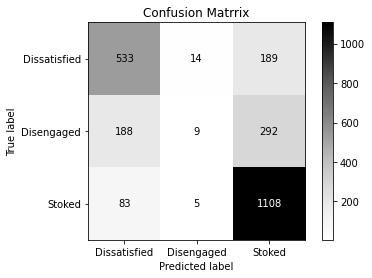

In [16]:
get_cm_plot(clf, X_test, y_test)

**Overall, there seems not much of change in the model performance. I would say if features are too obvious, probably the model will pick them up.**

### features importance

Need to mention that the following function performs on the latest model run as I have been using the same variable name across different versions of models.

In [17]:
get_feature_importance(vectorizer, clf, features)

20 most important features :

pos_neg_factor  :  0.028519055865242348
great  :  0.020377775378266228
management  :  0.01646211101751024
review_len  :  0.014118306050433349
no  :  0.013577022783706906
not  :  0.010956202537719945
good  :  0.009894595354200047
poor  :  0.008774026941519748
but  :  0.007380089303569977
of  :  0.007280721082001499
environment  :  0.007200450773819982
with  :  0.0071013109878772405
people  :  0.006881659549930978
for  :  0.00654391363304606
working  :  0.006471157754260246
terrible  :  0.005729926187048025
in  :  0.005727430990482114
is  :  0.005618705812940089
you  :  0.005473694359286228
are  :  0.005460067157394558

20 less important features :

equipped  :  6.224644627663978e-07
warehouse  :  5.010132258346312e-07
agreed  :  3.977338825248662e-07
band  :  3.2845095769017953e-07
conversation  :  2.9583935146203647e-07
steer  :  2.3950714092650545e-07
coach  :  1.7385892711817234e-07
decided  :  1.4786953798798415e-07
con  :  1.1513104719095879e-07
comman

### plot predictions

Following functions are used to generate an interactive `bokeh` plot of the test data set based on predicted labels, helping to investigate text data regarding its poor performance on label `class-1`.

Need to mention that they perform on the latest model run as I have been using the same variable name across different versions of models.

In [18]:
def get_visual_df(test_df, umap_vecs, y_predicted, X_test, features=None):
    """
    to create a dataframe for sake of visualization
    :param test_df: testing data set
    :param umap_vecs: 2D representation of text data
    :param y_predicted: a series of predicted labels
    :param X_test: a sparse matrix as testing set features
    :param features: list of engineered candidate features
    :return: a dataframe
    """
    if not features:
        visual_df = test_df[["reviews", "labels"]]
    else:
        visual_df = test_df[["reviews", "labels"]+features]
    
    visual_df["x"] = umap_vecs[:,0]
    visual_df["y"] = umap_vecs[:,1]
    visual_df["predicted_labels"] = y_predicted
    visual_df["predicted_labels"] = visual_df["predicted_labels"].astype(str)
    visual_df["probabilities"] = [x for x in clf.predict_proba(X_test)]
    
    return visual_df


def get_interactive_vec_plot(visual_df):
    """
    to visualize testing set of data for better access and exploration
    :param visual_df: pandas dataframe
    :return: bokeh plot instance
    """

    datasource = ColumnDataSource(visual_df)

    colour_mapper = CategoricalColorMapper(factors=["0", "1", "2"], 
                                           palette=["tomato", "black", "lightsteelblue"])

    TOOLTIPS = [
        ("id", "@index"),
        ("text", "@reviews"),
        ("label", "@labels"),
        ("probability", "@probabilities")
    ]

    hover = HoverTool(tooltips=TOOLTIPS)
    hover.attachment = 'right'

    plot = figure(
        title='2D-Vector Representation of Reviews and Predicted Labels',
        plot_width=600,
        plot_height=400,
        tools=('pan, wheel_zoom, reset', 'box_zoom', 'undo')
    )

    plot.add_tools(hover)

    plot.circle(
        'x', 
        'y', 
        source=datasource, 
        color=dict(field="predicted_labels", transform=colour_mapper), 
        legend="predicted_labels"
    )

    return plot

In [19]:
reducer = umap.UMAP()

sparse_matrix = vstack(test_df["vectors"])
umap_vecs = reducer.fit_transform(sparse_matrix)

visual_df = get_visual_df(test_df, umap_vecs, y_predicted, X_test, features)

output_notebook()
plot = get_interactive_vec_plot(visual_df)
show(plot)

Loading BokehJS ...

Or following lines of code can be used to investigate data through dataframe itself.

In [20]:
pd.options.display.max_colwidth = 500
visual_df[(visual_df.labels==1) | (visual_df.predicted_labels=="1")
         ][["reviews", "labels", "predicted_labels", "probabilities"]]

,reviews,labels,predicted_labels,probabilities
2103,‘Stable company to work for’ Staff discount flexible hours Keeping up to coles standards,1,2,"[0.12, 0.22, 0.66]"
1474,‘Like everywhere it comes down to the store you work at in general not the overall Coles company.’ Friendly people. Convenient. Short staff.,1,0,"[0.44, 0.16, 0.4]"
2997,"‘Woolworths is a challenging company which allows you to strive to do the best work you can, while being a rewarding career.’ The flexibility the company has for Uni students to maintain a healthy work-life balance. Also, the pay rate is quite high comparing to most other companies that offer the amount of flexibility Woolworths allows. The standards Woolworths has makes it difficult to perform your job efficiently. Also, the amount of work that usually has to be achieved is quite high and m...",1,2,"[0.18, 0.2, 0.62]"
7208,"‘What doesnt kill you makes you stronger’ Working with some great people, 2 brilliant managers that made work fantastic and enabled my to be very successful. Management and lack of control \r\nI had 7 managers in 13 years this isn't good for anyone",1,2,"[0.24, 0.2, 0.56]"
42,‘I have worked with the company a long time . Things are far tougher than they used to be and people are under too much pressure it is not enjoyable.’ If you have an engaged and encouraging manager working for this company is great.\nUnfortunately there are few left as the pressure that is placed on managers has seen all the good ones leave or step down. Getting good team members that want a job and want to come to work.\nToo many people are more concerned about how too many hours wil...,1,0,"[0.35, 0.33, 0.32]"
...,...,...,...,...
11931,"‘Average’ Incentives Staff, pressure, stress, behaviour.0",1,2,"[0.16, 0.4, 0.44]"
7131,‘Great place and opportunity to start but difficult to climb the corporate ranks.’ Good place to start working for new graduates/migrants seeking to gain experience in the Financial Services industry with focus on equity markets and instruments. The company structure and work scope makes it a little hard to get promotion and achieve higher work responsibilities.,1,2,"[0.08, 0.27, 0.65]"
4689,"‘It is different than the other retail jobs and the different is in a good way and the customers are great. ALDI is overall a motivator for my life. Definetely you will be more active than ever before and you will love it.’ I meet various customers during my shifts and love serving them at the best and helping them out with their needs and make sure they repeat the business. It is a very challenging every minute to get the work done, no matter what time is your shift or what kind of job you ...",1,2,"[0.18, 0.17, 0.65]"
4068,"‘A very boring experience’ The work is easy, small learning curve Unrealistic expectations from management",1,2,"[0.24, 0.29, 0.47]"


## infrence function

Use the following function to get predicted probabilities for any array of text.

Need to mention that they perform on the latest model run as I have been using the same variable name across different versions of models.

In [21]:
def get_prediction_proba(text, vectorizer, clf, features=None):
    infr_df = pd.DataFrame([text], columns=["reviews"])
    infr_df = get_features(infr_df.copy())
    infr_vectors = vectorizer.transform(infr_df["reviews"])
    if not features:
        infr_features = vstack(infr_vectors)
    else:
        helping_features = infr_df[features].astype(float)
        infr_features = hstack([vstack(infr_vectors), helping_features])
    infr_proba = clf.predict_proba(infr_features)

    print("Probabilities of input text being labeled as:\n\
    0 -> Dissatisfied : {}\n\
    1 -> Disengaged   : {}\n\
    2 -> Stokrd       : {}".format(infr_proba[0][0], infr_proba[0][1], infr_proba[0][2]))

In [22]:
text = """Not the worst but not the best.’ Subsidy to participate in health activities 
like 'around the bay' Immature Project Management structures. Poor quality of Project 
staff, especially Project managers. No new blood, most management are those been there 
for >20 years and still set in old ways."""

get_prediction_proba(text, vectorizer, clf, features)

Probabilities of input text being labeled as:
    0 -> Dissatisfied : 0.75
    1 -> Disengaged   : 0.17
    2 -> Stokrd       : 0.08
